In [153]:
from IPython.core.display import HTML
with open('./style.css') as f:
    css = f.read()
HTML(css)

In [154]:
import chess                                       # Simulate the chess game
import chess.gaviota                               # Load Gaviota Tablebase
from IPython.display import display, clear_output  # Better visualization and display of the chess board
import random                                      # Random moves and random creation of endgame positions
from typing import Union, List, Set                # Types to enable direct method signatures
import re          

<div style="text-align: justify">
(a) Zunächst wird die Menge aller möglichen zulässigen Stellungen berechnet.  Diese Menge
       bezeichnen wir mit S.  (Eine Stellung ist unzulässig, wenn der König des Spielers,
       der nicht am Zug ist, im Schach steht.)
</div>

In [155]:
def shift_positions(positions: List[int]) -> List[int]:
    for i, pos in enumerate(positions[::-1]):
        if pos == 63: 
            positions[-(i+1)] = 0
            continue
        else: 
            positions[-(i+1)] += 1
            break

    return positions

shift_positions([0, 1, 63, 63])

[0, 2, 0, 0]

In [156]:
#TODO: Add bishop validation
def generate_positions(pieces: List[chess.Piece]) -> set[str]:

    s = set()

    board = chess.Board()
    board.clear()

    for turn in [chess.WHITE, chess.BLACK]:
        board.turn = turn
        positions = [0] * len(pieces)
        while positions != [63] * len(pieces):
            board.clear_board()
            for i in range(len(pieces)):
                board.set_piece_at(positions[i], pieces[i])

            if board.is_valid() and len(set(positions)) == len(pieces):
                s.add(board.epd())

            positions = shift_positions(positions)

    return s

In [82]:
s = generate_positions([chess.Piece(chess.KING, chess.WHITE), chess.Piece(chess.KING, chess.BLACK), chess.Piece(chess.ROOK, chess.BLACK)])

In [83]:
len(s)

399112

<div style="text-align: justify">
(b) Anschließend werden alle Stellungen aus der Menge S gesucht, in denen der Spieler, der am Zug ist,
       schachmatt ist.  Diese Stellungen werden zu einer Menge S_0 zusammengefasst.  Außerdem werden diese
       Stellungen aus der Menge S entfernt.
</div>
<br>
S: Alle validen Stellungen, Weiß ist am Zug und schwarz ist am Zug
<br>
S0: Alle Stellungen in denen der Spieler, der am Zug ist, schachmatt ist
<br>
S1: Alle Stellungen in denen der Spieler, der am Zug ist, den Gegner mit einem Zug schachmatt setzen kann
<br>
S2: Alle Stellungen in denen der Spieler, der am Zug ist, nur Züge hat, die in S1 enden
<br>
Sn (n is unequal): Alle Stellungen in denen der Spieler, der am Zug ist, einen Zug hat, der in Sn-1 endet
<br>
Sn (n is equal): Alle Stellungen in denen der Spieler der am Zug ist, nur Züge hat, die in Sn-1 enden

In [157]:
def generate_mate_positions(s: Set[str]) -> Set[str]:
    s_0 = set()
    for i, epd in enumerate(s):

        if i%1000 == 0: 
            print("\r", end="")
            print(f"{i}/{len(s)} -> {int((i/len(s))*100)}%", end="")
        
        if chess.Board(epd).is_checkmate():
            s_0.add(epd)
    s = set(s) - s_0
    return s, s_0

In [85]:
s, s_0 = generate_mate_positions(s)

216


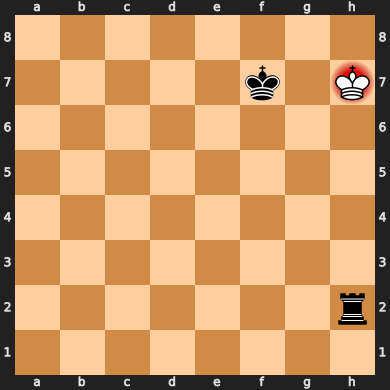

In [86]:
print(len(s_0))
display(chess.Board(list(s_0)[0]))

(c) Nun werden alle Stellungen aus S berechnet, in denen der Spieler mit seinem nächsten Zug den Gegner Matt setzen kann, d.h. eine Stellung aus der Menge S_0 erreichen kann. Diese Stellungen werden zu einer Menge S_1 zusammen gefasst und aus der Menge S entfernt. S_1 enthält also alle die Stellungen, in denen der Gegener unmittelbar matt gesetzt werden kann.

### Where DTM = 1

In [158]:
def generate_dtm1_positions(s: Set[str], s_prev: Set[str]) -> Set[str]:
    s_next = set()
    board = chess.Board()
    
    for i, epd in enumerate(s):

        if i%1000 == 0: 
            print("\r", end="")
            print(f"{i}/{len(s)} -> {int((i/len(s))*100)}%", end="")
        
        board.set_epd(epd)
        for move in board.legal_moves:
            board.push(move)
            if board.epd() in s_prev:
                board.pop()
                s_next.add(board.epd())
                break
            board.pop()

    s = set(s) - s_next
    return s, s_next

In [88]:
s, s_1 = generate_dtm1_positions(s, s_0)

398000/398896 -> 99%


1512


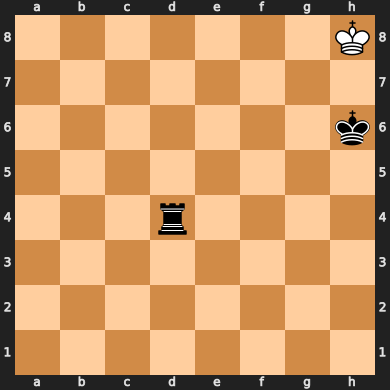

3K4/5r2/3k4/8/8/8/8/8 b - -


In [93]:
print(len(s_1))
display(chess.Board(list(s_1)[0]))
print(list(s_1)[1])

(d) Danach werden alle Stellungen aus S berechnet, in denen der Spieler, der am Zug ist, mit jedem seiner Züge in einer Stellung aus der Menge S_1 landet, also matt gesetzt werden kann. Diese Stellungen werden zu einer Menge S_2 zusammen gefasst und aus S entfernt. S_2 enthält also die Stellungen, in denen der Spieler der am Zug ist, im nächsten Zug matt gesetzt werden kann, unabhängig davon, wie er selber zieht.

In [159]:
def generate_dtm2_positions(s: Set[str], s_prev: Set[str]) -> Set[str]:
    s_next = set()

    for i, epd in enumerate(s):

        if i%1000 == 0: 
            print("\r", end="")
            print(f"{i}/{len(s)} -> {int((i/len(s))*100)}%", end="")

        board = chess.Board(epd)
        legal_moves = board.legal_moves
        fail = not legal_moves
        
        for move in legal_moves:
            board.push(move)
            if board.epd() not in s_prev:
                fail = True
                break
            board.pop()
        
        if not fail:
            s_next.add(epd)

    s = set(s) - s_next
    return s, s_next

In [134]:
s, s_2 = generate_dtm2_positions(s, s_1)

692
8/7r/8/8/8/5k2/8/6K1 w - -


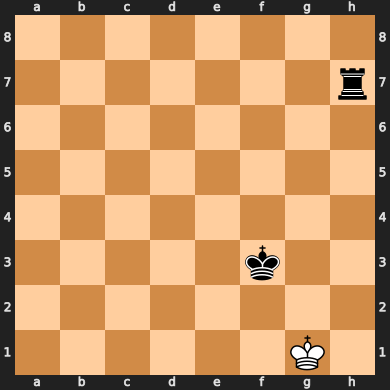

In [117]:
print(len(s_2))
ex_pos = list(s_2)[500]
print(ex_pos)
display(chess.Board(ex_pos))

In [160]:
def generate_sets(pieces):
    
    print(f"Doing all positions")
    s = generate_positions(pieces)
    print(f"Length of s = {len(s)}")
    print(f"--------------------------------------------------------------------------------------------")

    print(f"Doing mate positions")
    s, s_n = generate_mate_positions(s)
    print(f"\nLength of s_0 = {len(s_n)}")
    print(f"New length of s = {len(s)}")
    print(f"--------------------------------------------------------------------------------------------")
    yield s_n

    n = 0
    
    while s_n != set():
        n+=1
        
        #generate_dtm1_positions(s, exec(f"s_{n}"))
        #yield exec(f"s_{n}")
        if n % 2 == 1:
            print(f"Doing dtm{n}")
            s, s_n = generate_dtm1_positions(s, s_n)
        else:
            print(f"Doing dtm{n}")
            s, s_n = generate_dtm2_positions(s, s_n)

        print(f"\nLength of s_{n} = {len(s_n)}")
        print(f"New length of s = {len(s)}")
        print(f"--------------------------------------------------------------------------------------------")

        yield s_n
        
        

In [161]:
def save_set_as_file(s: Set[str], n: int, pieces_str: str) -> None:
    with open(f"./tables/{pieces_str}.txt", "a") as f:
        f.write(f"s_{n} = {s} \n")

In [162]:
def main():
    pieces = [chess.Piece(chess.KING, chess.WHITE), chess.Piece(chess.KING, chess.BLACK), chess.Piece(chess.ROOK, chess.BLACK)]
    gen = generate_sets(pieces)
    pieces_str = "".join([str(x) for x in pieces])

    for n, s_n in enumerate(gen):
        save_set_as_file(s_n, n, pieces_str)

In [152]:
main()

Doing all positions
Length of s = 399112
--------------------------------------------------------------------------------------------
Doing mate positions
399000/399112 -> 99%
Length of s_0 = 216
New length of s = 398896
--------------------------------------------------------------------------------------------
Doing dtm1
165000/398896 -> 41%

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f6e34dfb-c85e-40db-bde6-d0ca8b0148c0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>